# 데이터 로드 및 정제

In [22]:
import os,sys
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
import shap
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# Code 경로 추가
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(""))))
print(sys.path[-1])

/Users/jejunlee/myproject/boostcamp/LEVEL_1/Project_1/level1-classificationinmachinelearning-recsys-06


In [5]:
# 파일 호출
data_path: str = "../../../code/data"
## raw.csv가 없는 경우 실행
from Code.dataset.merge_all import merge_all
df = merge_all(data_path)
df: pd.DataFrame = pd.read_csv(os.path.join(data_path,"raw.csv"))
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출


100%|██████████| 107/107 [00:01<00:00, 63.06it/s]


In [7]:
# 원본 데이터프레임 손상 방지를 위해 새로운 데이터 프레임 df_copy 생성
df_copy: pd.DataFrame = df.copy()
print(df_copy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11552 entries, 0 to 11551
Columns: 255 entries, ID to hourly_market-data_open-interest_htx_global_btc_usdt_open_interest
dtypes: float64(250), int64(3), object(2)
memory usage: 22.5+ MB
None


# EDA
- hourly_market-data_price-ohlcv 내에는 특정 시간대의 **close**값만 존재합니다. target 값 예측의 근거인 등락률을 구하기 위해 df_copy에 **open** 열을 추가합니다.
- 현재 시간의 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_open'열을 이전 시간대의 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close'로 가져옵니다.
- target 값과 비교를 위해 open-close price의 등락 백분율을 구하는 'price_rate' 열을 추가합니다.

In [11]:
# open price 열 추가
df_copy["hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_open"] = df_copy["hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close"].shift(1)

# open price와 close price의 등락 백분율을 구해 추가
df_copy["price_rate"] = (df_copy["hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close"] - df_copy["hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_open"]) / df_copy["hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_open"] * 100
df_copy[["ID", "target", "price_rate"]].head(10)

,ID,target,price_rate
0,2023-01-01 00:00:00,2.0,NaN
1,2023-01-01 01:00:00,1.0,0.123292
2,2023-01-01 02:00:00,1.0,-0.054277
3,2023-01-01 03:00:00,1.0,-0.087725
4,2023-01-01 04:00:00,2.0,-0.053955
5,2023-01-01 05:00:00,2.0,0.028417
6,2023-01-01 06:00:00,1.0,0.073340
7,2023-01-01 07:00:00,1.0,-0.056395
8,2023-01-01 08:00:00,2.0,-0.079826
9,2023-01-01 09:00:00,2.0,0.132084


- 'target'과 'price_rate' 간의 데이터가 맞지 않아 'target' 데이터를 한 칸씩 밀고, 결측값이 되는 0번째 행과 미뤄진 결과 새롭게 생기는 마지막행을 제외하여 데이터프레임을 재정의합니다.

In [12]:
df_copy = df_copy.iloc[1:-1]
df_copy

,ID,target,_type,hourly_market-data_liquidations_gate_io_all_symbol_long_liquidations,hourly_market-data_liquidations_gate_io_all_symbol_short_liquidations,hourly_market-data_liquidations_gate_io_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_gate_io_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_ftx_btc_usd_open_interest,hourly_market-data_open-interest_bybit_open_interest,hourly_market-data_funding-rates_bybit_funding_rates,...,hourly_market-data_liquidations_huobi_global_btc_usdt_short_liquidations,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd,hourly_market-data_liquidations_huobi_global_btc_usdt_short_liquidations_usd,hourly_market-data_liquidations_htx_global_btc_usdt_long_liquidations,hourly_market-data_liquidations_htx_global_btc_usdt_short_liquidations,hourly_market-data_liquidations_htx_global_btc_usdt_long_liquidations_usd,hourly_market-data_liquidations_htx_global_btc_usdt_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usdt_open_interest,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_open,price_rate
1,2023-01-01 01:00:00,1.0,train,0.0,0.0,0.0,0.0,NaN,NaN,0.01,...,0.0,0.0,0.0,0.000,0.000,0.0000,0.0000,6.788941e+07,16536.747967,0.123292
2,2023-01-01 02:00:00,1.0,train,0.0,0.0,0.0,0.0,NaN,NaN,0.01,...,0.0,0.0,0.0,0.000,0.000,0.0000,0.0000,6.781657e+07,16557.136536,-0.054277
3,2023-01-01 03:00:00,1.0,train,0.0,0.0,0.0,0.0,NaN,NaN,0.01,...,0.0,0.0,0.0,0.000,0.000,0.0000,0.0000,6.798192e+07,16548.149805,-0.087725
4,2023-01-01 04:00:00,2.0,train,0.0,0.0,0.0,0.0,NaN,NaN,0.01,...,0.0,0.0,0.0,0.000,0.000,0.0000,0.0000,6.829002e+07,16533.632875,-0.053955
5,2023-01-01 05:00:00,2.0,train,0.0,0.0,0.0,0.0,NaN,NaN,0.01,...,0.0,0.0,0.0,0.000,0.000,0.0000,0.0000,6.850430e+07,16524.712159,0.028417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11546,2024-04-26 02:00:00,NaN,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.108,0.175,6926.7650,11317.9534,9.883205e+07,NaN,NaN
11547,2024-04-26 03:00:00,NaN,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.138,0.034,8852.6173,2197.9436,9.916199e+07,NaN,NaN
11548,2024-04-26 04:00:00,NaN,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.375,0.106,88004.5038,6836.7439,9.890358e+07,NaN,NaN
11549,2024-04-26 05:00:00,NaN,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.378,1.400,24154.4771,90469.5577,9.913138e+07,NaN,NaN


- 여러 피처들 중에서 전체적인 데이터에 대한 예측을 하기 위해 'all_exchange' 데이터만 솎아냅니다.

In [50]:
columns = df_copy.filter(like='all_exchange').columns
df_new = df_copy[["ID", "target", "_type", "price_rate"] + list(columns)]

In [51]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11550 entries, 1 to 11550
Data columns (total 19 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   ID                                                                              11550 non-null  object 
 1   target                                                                          8759 non-null   float64
 2   _type                                                                           11550 non-null  object 
 3   price_rate                                                                      8759 non-null   float64
 4   hourly_market-data_open-interest_all_exchange_all_symbol_open_interest          11547 non-null  float64
 5   hourly_market-data_funding-rates_all_exchange_funding_rates                     11519 non-null  float64
 6   hourly_market-

- 새롭게 생성된 df_new의 정보를 살펴보니 'hourly_market-data_open-interest_all_exchange_open_interest' 피처는 모두 비어있습니다.
- 해당 파일의 원본 데이터를 확인하여 문제점을 파악합니다.

In [52]:
# 피처 'hourly_market-data_open-interest_all_exchange_open_interest'의 원본 파일을 살펴봅니다.
open_interest_file_path = os.path.join(data_path, "hourly_market-data_open-interest_all_exchange.csv")

# Check if the file exists
if os.path.exists(open_interest_file_path):
    open_interest_df = pd.read_csv(open_interest_file_path)
    print(open_interest_df.info())
    print(open_interest_df.head())
else:
    print(f"File not found: {open_interest_file_path}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32197 entries, 0 to 32196
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       32197 non-null  object 
 1   open_interest  32197 non-null  float64
dtypes: float64(1), object(1)
memory usage: 503.2+ KB
None
              datetime  open_interest
0  2022-11-30 03:00:00   6.618043e+09
1  2022-11-30 02:00:00   6.662443e+09
2  2022-11-30 01:00:00   6.579798e+09
3  2022-11-30 01:00:00   6.579798e+09
4  2022-11-30 00:00:00   6.528951e+09


In [53]:
# 'hourly_market-data_open-interest_all_exchange_open_interest' 피처는 훈련시켜야 하는 2023년의 데이터를 가지고 있지 않아, df_new 데이터프레임에 추가하지 않습니다.
df_new = df_new.drop(columns=["hourly_market-data_open-interest_all_exchange_open_interest"])

In [54]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11550 entries, 1 to 11550
Data columns (total 18 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   ID                                                                              11550 non-null  object 
 1   target                                                                          8759 non-null   float64
 2   _type                                                                           11550 non-null  object 
 3   price_rate                                                                      8759 non-null   float64
 4   hourly_market-data_open-interest_all_exchange_all_symbol_open_interest          11547 non-null  float64
 5   hourly_market-data_funding-rates_all_exchange_funding_rates                     11519 non-null  float64
 6   hourly_market-

In [64]:
eda_df = df_new.loc[df["_type"] == "train"]

# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()
print(missing_values)

ID                                                                                0
target                                                                            0
_type                                                                             0
price_rate                                                                        0
hourly_market-data_open-interest_all_exchange_all_symbol_open_interest            0
hourly_market-data_funding-rates_all_exchange_funding_rates                       0
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume             0
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume            0
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio              0
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio             0
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio         0
hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations   

In [65]:
# 칼럼의 rename rule 정의
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
"hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
"hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "taker_buy_volume",
"hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "taker_sell_volume",
"hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "taker_buy_sell_ratio",
"hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
"hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
"hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume": "volume",
"hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_open": "open_price",
"hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close": "close_price",
"price_rate": "price_rate"
}

eda_df = eda_df[cols_dict.keys()].rename(cols_dict, axis=1)

/Users/jejunlee/miniconda3/envs/boostcamp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.

/Users/jejunlee/miniconda3/envs/boostcamp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 52376 (\N{HANGUL SYLLABLE CEO}) missing from font(s) DejaVu Sans.

/Users/jejunlee/miniconda3/envs/boostcamp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from font(s) DejaVu Sans.

/Users/jejunlee/miniconda3/envs/boostcamp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.

/Users/jejunlee/miniconda3/envs/boostcamp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.

/Users/jejunlee/miniconda3/envs/boostcamp/lib/pyth

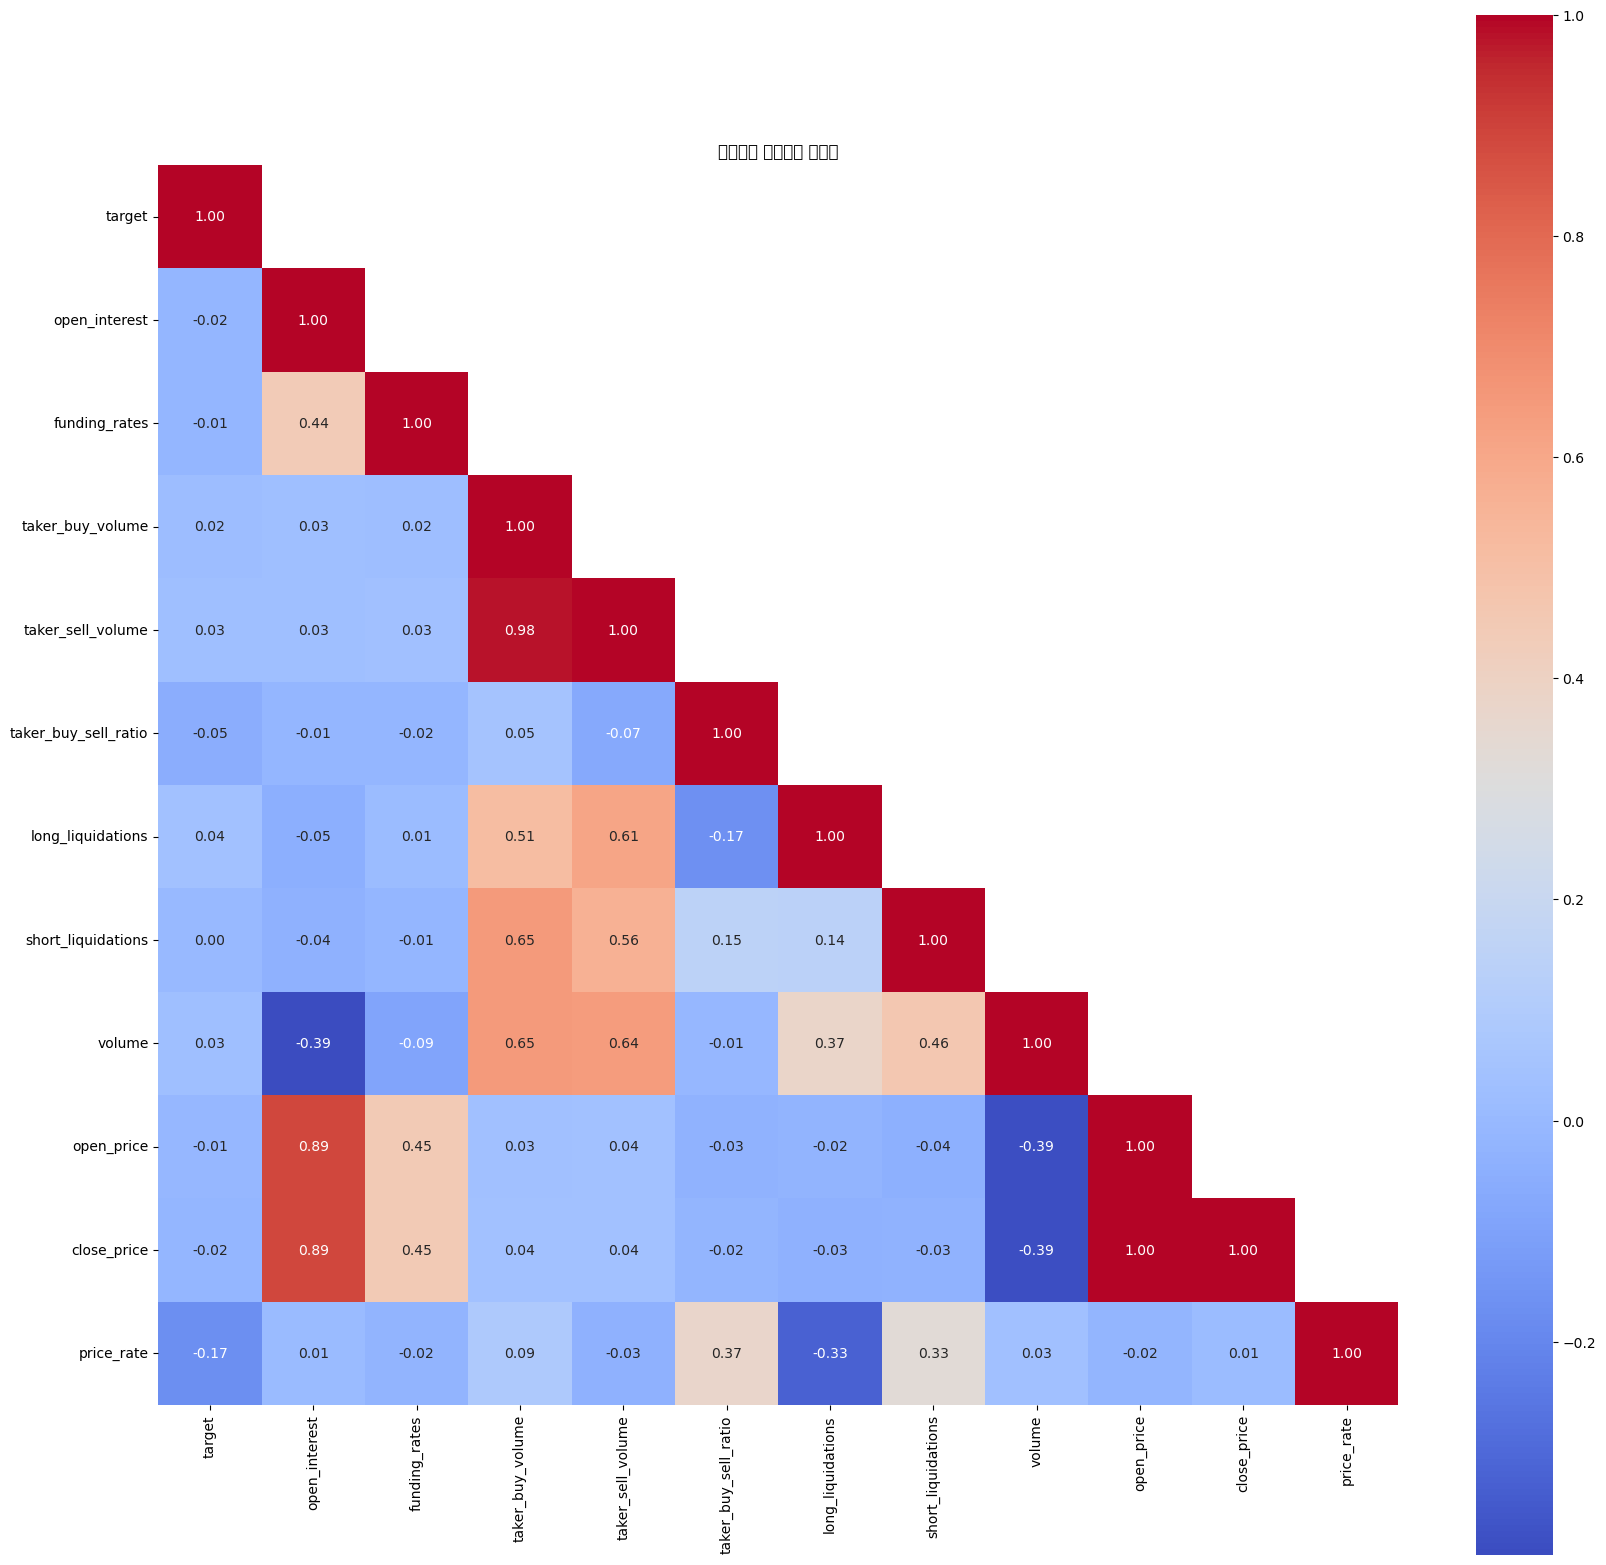

In [66]:
correlation_matrix = eda_df.drop(columns=['ID']).corr()
correlation_matrix = correlation_matrix.dropna(axis=1, how="all")

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, mask=np.triu(correlation_matrix, k=1))
plt.title("피처들의 상관관계 히트맵")
plt.show()

In [67]:
# 타겟 레이블 분포
eda_df["target"].value_counts()/len(eda_df)

target
2.0    0.418998
1.0    0.404612
3.0    0.091905
0.0    0.084485
Name: count, dtype: float64

In [68]:
# 타겟 값 별로 변수의 평균 파익
bar_df = eda_df.groupby("target").agg({
    "open_interest" : "mean",
    "funding_rates" : "mean",
    "taker_buy_volume" : "mean",
    "taker_sell_volume" : "mean",
    "taker_buy_sell_ratio" : "mean",
    "long_liquidations" : "mean",
    "short_liquidations" : "mean",
    "volume" : "mean",
    "open_price" : "mean",
    "close_price" : "mean",
    "price_rate" : "mean"
}).reset_index()
bar_df

# 극단적인 경우, 즉 target 0, 3에서 평균적으로 long_liquidations, short_liquidations, volume, sell_volume, taker_buy_volume, taker_sell_volume 값이 커짐

,target,open_interest,funding_rates,taker_buy_volume,taker_sell_volume,taker_buy_sell_ratio,long_liquidations,short_liquidations,volume,open_price,close_price,price_rate
0,0.0,8.810355e+09,0.007483,4.046126e+08,4.037655e+08,1.004803,34.306873,35.351660,7260.855920,29568.602912,29643.533974,0.256620
1,1.0,8.519933e+09,0.007194,2.416815e+08,2.378602e+08,1.029377,15.403795,17.878903,4483.274070,28671.537034,28690.376933,0.065010
2,2.0,8.501224e+09,0.007193,2.381471e+08,2.442757e+08,0.993823,20.313958,15.906029,4495.917985,28677.381488,28666.763901,-0.034095
3,3.0,8.698922e+09,0.006617,4.306805e+08,4.376228e+08,1.002806,45.540121,37.819832,8242.800159,29172.021936,29100.590892,-0.228062


In [69]:
# 모든 피처에 대해 barplot을 이용한 시각화 코드 작성
fig: go.Figure = make_subplots(
    rows=6,
    cols=2,
    shared_xaxes=True,
    subplot_titles=(
        "target distribution",
        "open_interest",
        "funding_rates",
        "taker_buy_volume",
        "taker_sell_volume",
        "taker_buy_sell_ratio",
        "long_liquidations",
        "short_liquidations",
        "volume",
        "open_price",
        "close_price",
        "price_rate",
    ),
)

_target_distribution = eda_df["target"].value_counts() / len(eda_df)
fig.add_trace(
    go.Bar(
        x=_target_distribution.index, 
        y=_target_distribution,
    ), row=1, col=1
)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["open_interest"]), row=1, col=2)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["funding_rates"]), row=2, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["taker_buy_volume"]), row=2, col=2)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["taker_sell_volume"]), row=3, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["taker_buy_sell_ratio"]), row=3, col=2)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["long_liquidations"]), row=4, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["short_liquidations"]), row=4, col=2)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["volume"]), row=5, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["open_price"]), row=5, col=2)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["close_price"]), row=6, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["price_rate"]), row=6, col=2)

fig.update_layout(title_text="Target statistics for all features", showlegend=False)
fig.update_xaxes(title_text="Target", row=6)
fig.show()

In [79]:
conti_cols: List[str] = [
    "open_interest",
    "funding_rates",
    "taker_buy_volume",
    "taker_sell_volume",
    "taker_buy_sell_ratio",
    "long_liquidations",
    "short_liquidations",
    "volume",
    "open_price",
    "close_price",
    "price_rate",
]

def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=eda_df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

In [80]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

### Model Training

In [91]:
# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1), 
    train_df["target"].astype(int), 
    test_size=0.2,
    random_state=42,
)

# xgb dataset
train_data = xgb.DMatrix(x_train, label=y_train)
valid_data = xgb.DMatrix(x_valid, label=y_valid)

# xgb params
params = {
    "booster": "gbtree",
    "objective": "multi:softprob",
    "metric": "mlogloss",
    "num_class": 4,
    "learning_rate": 0.02,
    "max_depth": 6,
    "learning_rate": 0.05,
    "n_estimators": 50,
    "seed": 42,
    "verbose": 0,
}

# xgb train
xgb_model = xgb.train(
    params=params,
    dtrain=train_data,
    num_boost_round=100,
    evals=[(valid_data, "eval")],
    early_stopping_rounds=10,
)

# xgb predict
valid_dmatrix = xgb.DMatrix(x_valid)
y_valid_pred = xgb_model.predict(valid_dmatrix)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

[0]	eval-mlogloss:1.36961


/Users/jejunlee/miniconda3/envs/boostcamp/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[13:45:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1717011574866/work/src/learner.cc:742: 
Parameters: { "metric", "n_estimators", "verbose" } are not used.




[1]	eval-mlogloss:1.35433
[2]	eval-mlogloss:1.34030
[3]	eval-mlogloss:1.32675
[4]	eval-mlogloss:1.31451
[5]	eval-mlogloss:1.30273
[6]	eval-mlogloss:1.29228
[7]	eval-mlogloss:1.28209
[8]	eval-mlogloss:1.27308
[9]	eval-mlogloss:1.26396
[10]	eval-mlogloss:1.25572
[11]	eval-mlogloss:1.24781
[12]	eval-mlogloss:1.24030
[13]	eval-mlogloss:1.23287
[14]	eval-mlogloss:1.22671
[15]	eval-mlogloss:1.22023
[16]	eval-mlogloss:1.21454
[17]	eval-mlogloss:1.20910
[18]	eval-mlogloss:1.20359
[19]	eval-mlogloss:1.19854
[20]	eval-mlogloss:1.19413
[21]	eval-mlogloss:1.18972
[22]	eval-mlogloss:1.18563
[23]	eval-mlogloss:1.18121
[24]	eval-mlogloss:1.17746
[25]	eval-mlogloss:1.17365
[26]	eval-mlogloss:1.17037
[27]	eval-mlogloss:1.16687
[28]	eval-mlogloss:1.16375
[29]	eval-mlogloss:1.16103
[30]	eval-mlogloss:1.15821
[31]	eval-mlogloss:1.15563
[32]	eval-mlogloss:1.15353
[33]	eval-mlogloss:1.15079
[34]	eval-mlogloss:1.14864
[35]	eval-mlogloss:1.14649
[36]	eval-mlogloss:1.14457
[37]	eval-mlogloss:1.14243
[38]	eval-

In [94]:
# performance 체크후 전체 학습 데이터로 다시 재학습
x_train = train_df.drop(["target", "ID"], axis = 1)
y_train = train_df["target"].astype(int)

train_data = xgb.DMatrix(x_train, label=y_train)

xgb_model = xgb.train(
    params=params,
    dtrain=train_data,
)

/Users/jejunlee/miniconda3/envs/boostcamp/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[13:48:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1717011574866/work/src/learner.cc:742: 
Parameters: { "metric", "n_estimators", "verbose" } are not used.




### Inference

In [97]:
# xgb predict
test_data = xgb.DMatrix(test_df.drop(["target", "ID"], axis = 1))
y_test_pred = xgb_model.predict(test_data)
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

### Output File Save

In [18]:
# output file 할당후 save 
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("output.csv", index=False)